### imports

In [1]:
# imports

import io
import glob
import os
import sys
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft
import pandas as pd
import seaborn as sns
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# prompt: Access a folder on google drive and import the data locally
from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


### Loading results

In [3]:
all_results_df = pd.DataFrame()
for file in glob.glob('./Features Extraction Results/features_extraction_results*'):
  print(file)
  with open(file, 'rb') as f:
    all_results_df = all_results_df.append(pickle.load(f))

all_results_df.reset_index(drop=True, inplace=True)

./Features Extraction Results/features_extraction_results_01_20_2024, 21:26:14
./Features Extraction Results/features_extraction_results_01_21_2024, 05:43:12
./Features Extraction Results/features_extraction_results_01_21_2024, 06:18:31
./Features Extraction Results/features_extraction_results_01_22_2024, 06:47:07
./Features Extraction Results/features_extraction_results_01_22_2024, 07:28:08
./Features Extraction Results/features_extraction_results_01_22_2024, 07:41:17
./Features Extraction Results/features_extraction_results_01_22_2024, 09:20:06
./Features Extraction Results/features_extraction_results_01_22_2024, 13:18:35
./Features Extraction Results/features_extraction_results_01_22_2024, 13:24:23
./Features Extraction Results/features_extraction_results_01_22_2024, 21:19:19
./Features Extraction Results/features_extraction_results_01_22_2024, 21:36:27
./Features Extraction Results/features_extraction_results_01_24_2024, 07:58:06
./Features Extraction Results/features_extraction_re

In [4]:
all_results_df = all_results_df[all_results_df['Model'] == 'MLP']

In [5]:
len(all_results_df)

570

In [6]:
all_results_df.head(3)

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,UAV f1,Total f1,Training Config
1820,"01/24/2024, 07:58:06",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [80, 80], 'dropou...","{'airplane': {'precision': 0.8067632850241546,...",0.714286,0.909091,0.800000,0.901324,"{'batch_size': 16, 'optimizer_type': <class 't..."
1821,"01/24/2024, 07:58:06",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [80, 80], 'dropou...","{'airplane': {'precision': 0.8134715025906736,...",0.680365,0.967532,0.798928,0.890988,"{'batch_size': 16, 'optimizer_type': <class 't..."
1822,"01/24/2024, 07:58:06",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [80, 80], 'dropou...","{'airplane': {'precision': 0.7934272300469484,...",0.718232,0.844156,0.776119,0.892204,"{'batch_size': 32, 'optimizer_type': <class 't..."


In [7]:
def extract_from_column(df, col, field):
  return df[col].apply(lambda x: x[field])

def features_type(df):
  # extremum = extract_from_column(df, 'Features Config', 'extremum')
  # curve = extract_from_column(df, 'Features Config', 'curve')
  # f = zip(extremum, curve)
  d_map = {
    (True, True): 'all',
    (True, False): 'range dependent',
    (False, True): 'range independent',
    (False, False): 'none'
  }
  return df['Features Config'].apply(lambda x: d_map[(x['extremum'], x['curve'])])

def layers_sig(df):
  d_map = {
    sum([256, 128, 64, 32, 16]): 'c1',
    sum([80, 80]): 'c2',
    sum([256, 256, 128, 32]) : 'c3'
  }
  return df['Layers'].apply(lambda x: d_map[sum(x)])

In [8]:
all_results_df['Layers'] = extract_from_column(all_results_df, 'Model Config', 'layers')
all_results_df['Model Random State'] = extract_from_column(all_results_df, 'Model Config', 'model_random_state')
all_results_df['Split Random State'] = extract_from_column(all_results_df, 'Split Config', 'random_state')
all_results_df['Batch Size'] = extract_from_column(all_results_df, 'Training Config', 'batch_size')
all_results_df['optimizer_parameter'] = extract_from_column(all_results_df, 'Training Config', 'optimizer_parameter')
all_results_df['Learning Rate'] = extract_from_column(all_results_df, 'optimizer_parameter', 'lr')
all_results_df['Class Weights'] = extract_from_column(all_results_df, 'Training Config', 'class_weights')
all_results_df['Features Type'] = features_type(all_results_df)
all_results_df['Layers Config'] = layers_sig(all_results_df)

In [9]:
all_results_df.sample(10)

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,...,Training Config,Layers,Model Random State,Split Random State,Batch Size,optimizer_parameter,Learning Rate,Class Weights,Features Type,Layers Config
2322,"01/25/2024, 06:08:31",15,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 15, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 256, 128, 3...","{'airplane': {'precision': 0.7547169811320755,...",0.920000,0.730159,...,"{'batch_size': 64, 'optimizer_type': <class 't...","[256, 256, 128, 32]",42,42,64,{'lr': 0.001},0.0010,"[tensor(0.0053), tensor(0.0031), tensor(0.0222...",all,c3
1972,"01/24/2024, 08:59:36",20,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 20, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 1.0, 'recall': 0.42...",0.763158,0.935484,...,"{'batch_size': 32, 'optimizer_type': <class 't...","[256, 128, 64, 32, 16]",42,42,32,{'lr': 0.0001},0.0001,"[tensor(0.0070), tensor(0.0042), tensor(0.0385...",all,c1
2075,"01/24/2024, 15:44:48",15,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 15, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 0.9523809523809523,...",0.903226,0.888889,...,"{'batch_size': 32, 'optimizer_type': <class 't...","[256, 128, 64, 32, 16]",42,42,32,{'lr': 0.005},0.0050,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c1
1830,"01/24/2024, 07:58:06",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [80, 80], 'dropou...","{'airplane': {'precision': 0.776255707762557, ...",0.716667,0.837662,...,"{'batch_size': 64, 'optimizer_type': <class 't...","[80, 80]",42,42,64,{'lr': 0.0001},0.0001,"[tensor(0.0014), tensor(0.0011), tensor(0.0076...",all,c2
1973,"01/24/2024, 08:59:36",20,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 20, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 1.0, 'recall': 0.85...",0.805556,0.935484,...,"{'batch_size': 32, 'optimizer_type': <class 't...","[256, 128, 64, 32, 16]",42,42,32,{'lr': 0.0001},0.0001,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c1
1924,"01/24/2024, 08:59:36",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 0.8048780487804879,...",0.748691,0.928571,...,"{'batch_size': 32, 'optimizer_type': <class 't...","[256, 128, 64, 32, 16]",42,42,32,{'lr': 0.0003},0.0003,"[tensor(0.0014), tensor(0.0011), tensor(0.0076...",all,c1
2282,"01/25/2024, 06:08:31",10,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 10, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 256, 128, 3...","{'airplane': {'precision': 0.95, 'recall': 0.9...",0.803922,0.881720,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[256, 256, 128, 32]",42,42,16,{'lr': 0.0003},0.0003,"[tensor(0.0029), tensor(0.0023), tensor(0.0164...",all,c3
1990,"01/24/2024, 08:59:36",25,[NIR_airplane_20231024-7069_20231024-021810.js...,"{'sample_duration': 25, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 1.0, 'recall': 0.75...",0.934783,0.914894,...,"{'batch_size': 32, 'optimizer_type': <class 't...","[2

In [10]:
all_results_df[all_results_df['UAV f1'] == all_results_df['UAV f1'].max()]

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,...,Training Config,Layers,Model Random State,Split Random State,Batch Size,optimizer_parameter,Learning Rate,Class Weights,Features Type,Layers Config
2235,"01/24/2024, 20:09:26",25,[NIR_airplane_20231024-7069_20231024-021810.js...,"{'sample_duration': 25, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 256, 128, 3...","{'airplane': {'precision': 0.8846153846153846,...",0.938776,0.978723,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[256, 256, 128, 32]",42,42,16,{'lr': 0.005},0.005,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c3


In [11]:
all_results_df['Evaluation Report'].loc[2235]

{'airplane': {'precision': 0.8846153846153846,
  'recall': 0.696969696969697,
  'f1-score': 0.7796610169491526,
  'support': 33},
 'uav': {'precision': 0.8095238095238095,
  'recall': 0.918918918918919,
  'f1-score': 0.860759493670886,
  'support': 37},
 'bird': {'precision': 0.5,
  'recall': 0.3333333333333333,
  'f1-score': 0.4,
  'support': 6},
 'static-object': {'precision': 0.9615384615384616,
  'recall': 0.9920634920634921,
  'f1-score': 0.9765625,
  'support': 126},
 'accuracy': 0.9108910891089109,
 'macro avg': {'precision': 0.788919413919414,
  'recall': 0.7353213603213604,
  'f1-score': 0.7542457526550096,
  'support': 202},
 'weighted avg': {'precision': 0.9074184891016575,
  'recall': 0.9108910891089109,
  'f1-score': 0.9060583654710139,
  'support': 202}}

### Slicing

In [12]:
slice1_config = {
    'Learning Rate' : 0.0001,
    'Batch Size' : 32,
    'Features Type' : 'all'
}

In [13]:
# prompt: slice a dataframe according to a given column value dictionary

slice_df1 = all_results_df[all_results_df['Learning Rate'] == slice1_config['Learning Rate']]
# slice_df1 = slice_df1[slice_df1['Batch Size'] == slice1_config['Batch Size']]
# slice_df = slice_df[slice_df['Split Random State'] == slice_config['Split Random State']]


In [14]:
slice_df1.sample(5)

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,...,Training Config,Layers,Model Random State,Split Random State,Batch Size,optimizer_parameter,Learning Rate,Class Weights,Features Type,Layers Config
2337,"01/25/2024, 06:08:31",20,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 20, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 256, 128, 3...","{'airplane': {'precision': 0.9310344827586207,...",0.828571,0.935484,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[256, 256, 128, 32]",42,42,16,{'lr': 0.0001},0.0001,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c3
1880,"01/24/2024, 07:58:06",20,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 20, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [80, 80], 'dropou...","{'airplane': {'precision': 0.9615384615384616,...",0.843750,0.870968,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[80, 80]",42,42,16,{'lr': 0.0001},0.0001,"[tensor(0.0070), tensor(0.0042), tensor(0.0385...",all,c2
2187,"01/24/2024, 20:09:26",20,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 20, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 256, 128, 3...","{'airplane': {'precision': 0.9333333333333333,...",0.805556,0.935484,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[256, 256, 128, 32]",42,42,16,{'lr': 0.0001},0.0001,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c3
1883,"01/24/2024, 07:58:06",20,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 20, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [80, 80], 'dropou...","{'airplane': {'precision': 0.9642857142857143,...",0.783784,0.935484,...,"{'batch_size': 32, 'optimizer_type': <class 't...","[80, 80]",42,42,32,{'lr': 0.0001},0.0001,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c2
1936,"01/24/2024, 08:59:36",10,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 10, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 0.927710843373494, ...",0.743802,0.967742,...,"{'batch_size': 32, 'optimizer_type': <class 't...","[256, 128, 64, 32, 16]",42,42,32,{'lr': 0.0001},0.0001,"[tensor(0.0029), tensor(0.0023), tensor(0.0164...",all,c1


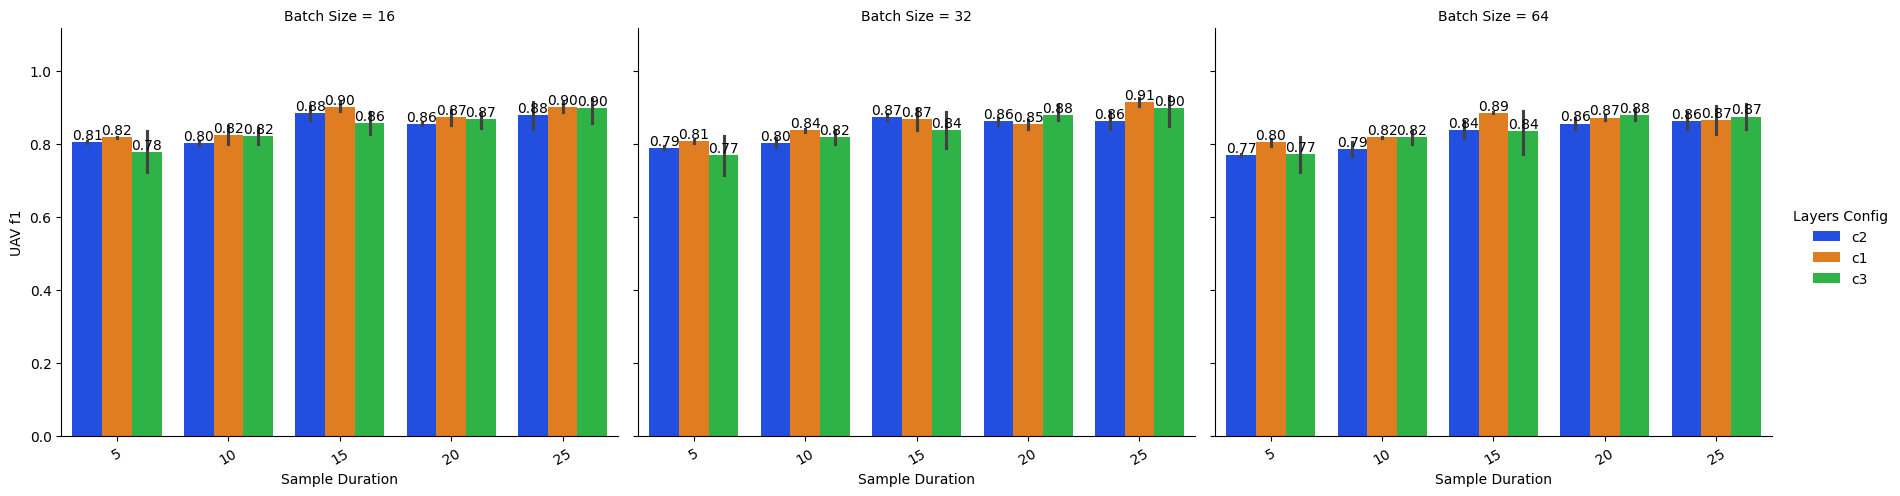

In [15]:
g = sns.catplot(data=slice_df1, x = "Sample Duration", y = "UAV f1", hue = "Layers Config", col="Batch Size", kind="bar", aspect=1.2, palette ="bright")

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)

In [16]:
slice2_config = {
    # 'Learning Rate' : 0.0001,
    'Batch Size' : 32,
    'Layers Config' : 'c3'
}

In [17]:
slice_df2 = all_results_df[all_results_df['Layers Config'] == slice2_config['Layers Config']]

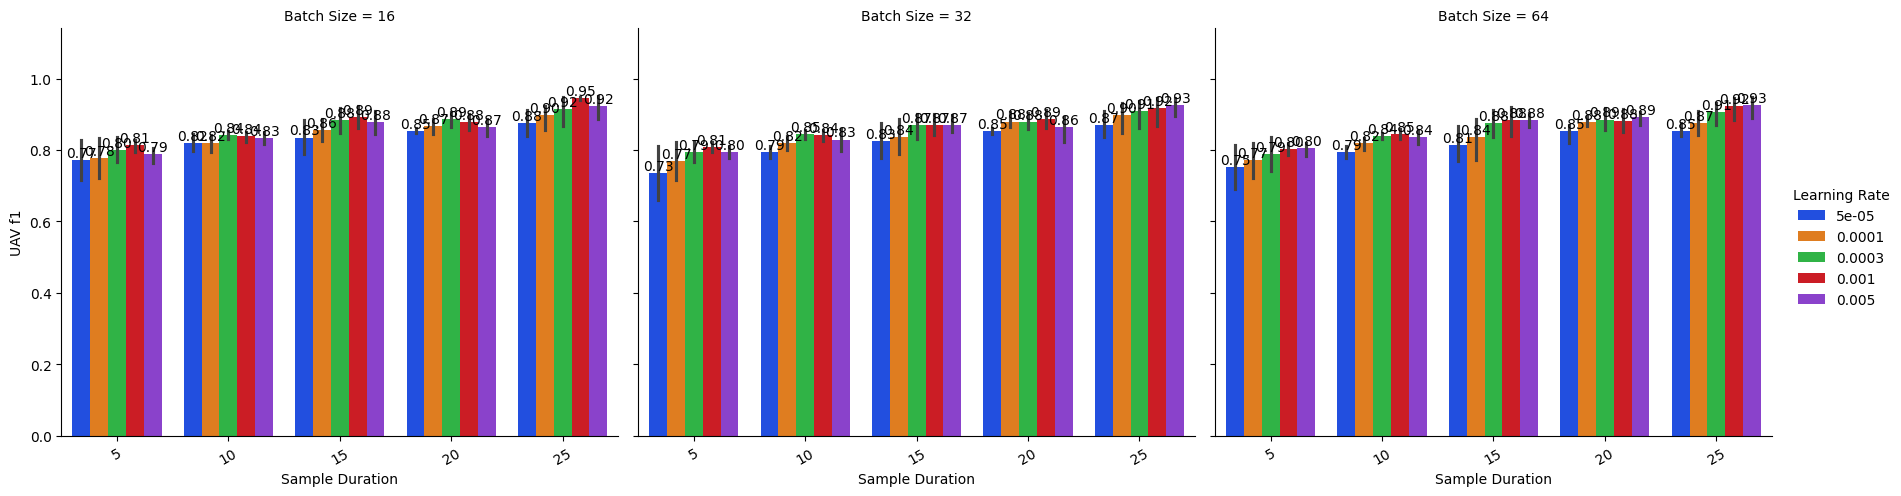

In [18]:
g = sns.catplot(data=slice_df2, x = "Sample Duration", y = "UAV f1", hue = "Learning Rate", col="Batch Size", kind="bar", aspect=1.2, palette ="bright")

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = ['%0.2f' % v for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='edge')
    # plt.xticks(rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.margins(y=0.2)

In [19]:
# slice_df2 = all_results_df[all_results_df['Learning Rate'] == slice1_config['Learning Rate']]
# slice_df1 = slice_df1[slice_df1['Batch Size'] == slice1_config['Features Type']]
# slice_df = slice_df[slice_df['Split Random State'] == slice_config['Split Random State']]


In [20]:
slice_df2[slice_df2['UAV f1'] == slice_df2['UAV f1'].max()]

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,...,Training Config,Layers,Model Random State,Split Random State,Batch Size,optimizer_parameter,Learning Rate,Class Weights,Features Type,Layers Config
2235,"01/24/2024, 20:09:26",25,[NIR_airplane_20231024-7069_20231024-021810.js...,"{'sample_duration': 25, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 256, 128, 3...","{'airplane': {'precision': 0.8846153846153846,...",0.938776,0.978723,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[256, 256, 128, 32]",42,42,16,{'lr': 0.005},0.005,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c3


In [21]:
slice_df2['Evaluation Report'].loc[2235]

{'airplane': {'precision': 0.8846153846153846,
  'recall': 0.696969696969697,
  'f1-score': 0.7796610169491526,
  'support': 33},
 'uav': {'precision': 0.8095238095238095,
  'recall': 0.918918918918919,
  'f1-score': 0.860759493670886,
  'support': 37},
 'bird': {'precision': 0.5,
  'recall': 0.3333333333333333,
  'f1-score': 0.4,
  'support': 6},
 'static-object': {'precision': 0.9615384615384616,
  'recall': 0.9920634920634921,
  'f1-score': 0.9765625,
  'support': 126},
 'accuracy': 0.9108910891089109,
 'macro avg': {'precision': 0.788919413919414,
  'recall': 0.7353213603213604,
  'f1-score': 0.7542457526550096,
  'support': 202},
 'weighted avg': {'precision': 0.9074184891016575,
  'recall': 0.9108910891089109,
  'f1-score': 0.9060583654710139,
  'support': 202}}

In [22]:
max_idx = all_results_df.groupby(['Sample Duration'])['UAV f1'].idxmax()
df_max = all_results_df.loc[max_idx.values]

In [23]:
df_max

,datetime,Sample Duration,Test Files,Split Config,Features Config,Model,Model Config,Evaluation Report,UAV precision,UAV recall,...,Training Config,Layers,Model Random State,Split Random State,Batch Size,optimizer_parameter,Learning Rate,Class Weights,Features Type,Layers Config
2097,"01/24/2024, 20:09:26",5,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 5, 'overlap_factor': 0.25,...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 256, 128, 3...","{'airplane': {'precision': 0.8548387096774194,...",0.756345,0.967532,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[256, 256, 128, 32]",42,42,16,{'lr': 0.0001},0.0001,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c3
2039,"01/24/2024, 15:14:30",10,[NIR_airplane_20231023-13275_20231023-181630.j...,"{'sample_duration': 10, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 0.9733333333333334,...",0.782609,0.967742,...,"{'batch_size': 32, 'optimizer_type': <class 't...","[256, 128, 64, 32, 16]",42,42,32,{'lr': 0.001},0.0010,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c1
2012,"01/24/2024, 14:49:47",15,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 15, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 0.8541666666666666,...",0.935484,0.920635,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[256, 128, 64, 32, 16]",42,42,16,{'lr': 0.0005},0.0005,"[tensor(0.0053), tensor(0.0031), tensor(0.0222...",all,c1
1981,"01/24/2024, 08:59:36",20,[NIR_airplane_20231023-15264_20231023-183229.j...,"{'sample_duration': 20, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 128, 64, 32...","{'airplane': {'precision': 0.875, 'recall': 1....",0.935484,0.935484,...,"{'batch_size': 64, 'optimizer_type': <class 't...","[256, 128, 64, 32, 16]",42,42,64,{'lr': 0.0003},0.0003,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c1
2235,"01/24/2024, 20:09:26",25,[NIR_airplane_20231024-7069_20231024-021810.js...,"{'sample_duration': 25, 'overlap_factor': 0.25...","{'date': 2012024, 'extremum': True, 'std': Tru...",MLP,"{'num_classes': 4, 'layers': [256, 256, 128, 3...","{'airplane': {'precision': 0.8846153846153846,...",0.938776,0.978723,...,"{'batch_size': 16, 'optimizer_type': <class 't...","[256, 256, 128, 32]",42,42,16,{'lr': 0.005},0.0050,"[tensor(0.1500), tensor(0.5000), tensor(0.2500...",all,c3


In [26]:
df_max.loc[2039]['Training Config']

{'batch_size': 32,
 'optimizer_type': torch.optim.adam.Adam,
 'optimizer_parameter': {'lr': 0.001},
 'class_weights': tensor([0.1500, 0.5000, 0.2500, 0.1000]),
 'criterion': torch.nn.modules.loss.CrossEntropyLoss,
 'n_epochs': 250,
 'early_stopping': 80,
 'verbose': False,
 'device': device(type='cuda')}

In [27]:
df_max.loc[2039]['Model Config']

{'num_classes': 4,
 'layers': [256, 128, 64, 32, 16],
 'dropout': 0,
 'model_random_state': 42,
 'num_features': 79}